In [1]:
%pylab inline
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import scikit_posthocs as sp
import string, os
sns.set(style='ticks', font_scale=1.5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
## read the data
data = pd.read_csv('processed_data_table.csv')

In [3]:
## Look only at interspeciefic effects (excluding intraspecific ones) 
data_different_bugs = data[data['Bug 1']!=data['Bug 2']]

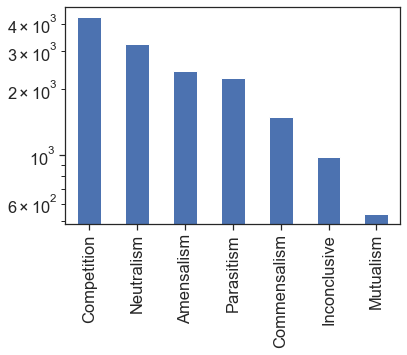

In [4]:
ax = data_different_bugs.Class.value_counts().plot(kind='bar')
ax.set_yscale('log')

In [5]:
## group interaction by species in order to compute how much interactions between a given pair changes across carbon environments
working_data = data_different_bugs
g_bugs = working_data.groupby(['Bug 1', 'Bug 2'])

## Claculate the qualitative stability of interaction class

### across carbon environments

In [6]:
def get_class_stability(g):
    '''
    Calculate the stability of the interaction class of a group (g) of interaction classes.
    
    Stability is defined as the probability that the interaction class stays the same if another class from the group (g) is chosen at random.
    If the group represents all the interactions of a pair of species across carbon environments, this corresponds to the "environemt stability". 
    If the group represents all the interactions of a given species in a given carbon env across other species, this corresponds to the "species stability".
    '''
    c_class = g.Class.value_counts()
    if 'Inconclusive' in c_class:
        c_class.drop('Inconclusive', inplace=True)
    s = (c_class-1)/(c_class.sum()-1) 
    return s

In [7]:
## claculate the stability of each interaction class for each species pair (=prob that interaction class changes when carbon env changes) 
c_stability = g_bugs.apply(get_class_stability)
c_stability = c_stability.reset_index().rename(columns={'level_2':'class','Class':'stability'})

In [8]:
order = ['Mutualism', 'Commensalism', 'Neutralism', 'Amensalism', 'Parasitism', 'Competition']

def get_letters(ps, th=0.01):
    '''
    Get the ompact letter display of the different interaction classes at a given th based on the pairwise p-values DataFRame (ps)
    
    **    Note that this is not a general utility function. It is not guaranteed to always return the right clr display and need to be verfied manually.
    '''
    current_letter = 0

    l = {}
    th = 0.01
    for i in range(0, len(order)):
        ci = order[i]
        cij = order[:i]
        pij = ps.loc[ci,cij]
        bi = (pij>th)
        cs = bi.index[bi]
        if not len(cs):
            l[ci] = string.ascii_lowercase[current_letter]
            current_letter+=1
        else:
            l[ci] = ''.join([l[c] for c in cs])
    return l

In [9]:
## compute the all pairwise p-values
ps = sp.posthoc_dunn(c_stability, val_col='stability', group_col='class', p_adjust = 'bonferroni').loc[order,order]
letters = get_letters(ps)

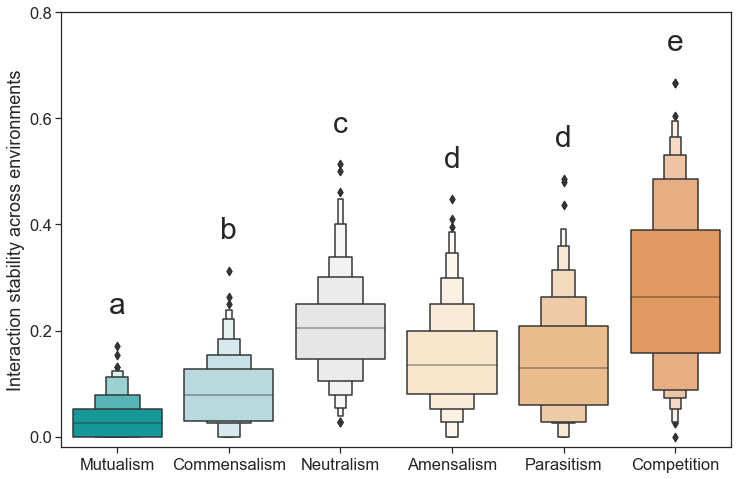

In [10]:

pal = {'Mutualism': '#00AEAF', 
       'Commensalism':'#B2DFE5', 
       'Neutralism':'#E6E6E6', 
       'Amensalism':'#FFE7C5', 
       'Parasitism':'#FABD7E', 
       'Competition':'#F7954C'}

fig, ax = subplots(figsize=(12,8))
sns.boxenplot(data=c_stability, x='class', y='stability', palette=pal, order=order)
ax.set_xlabel('')
# ax.set_ylabel('Stability\n(prob. of same interaction class in different env)', ma='center')
ax.set_ylabel('Interaction stability across environments', ma='center')


c_stability_max = c_stability.groupby('class').max()
for i,c in enumerate(order):
    y = 0.05 + c_stability_max.loc[c, 'stability']
    s = letters[c]
    ax.text(i, y, s, ha='center', va='bottom', fontsize=30)
    
ax.set_ylim(-.02,.8)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
# savefig('Interaction_stability_env.png', dpi=300, bbox_inches='tight')

In [11]:
data_file = pd.ExcelWriter(os.getcwd() + "\\Fig_4_data.xlsx", engine = 'xlsxwriter')
pval_file = pd.ExcelWriter(os.getcwd() + "\\Fig_4_pvalues.xlsx", engine = 'xlsxwriter')

s_name = 'stability_across_environments'
ps.to_excel(pval_file, sheet_name=s_name)
c_stability.to_excel(data_file, sheet_name=s_name)

### across species

In [12]:
## group interaction by carbon env (such that each group contains all the interactions of a given species in a given carbon env with all other species) in order to compute how much interactions changes when one of the interacting species is switched
g_carbon = working_data.groupby(['Bug 1', 'Carbon'])

In [13]:
## claculate the stability of each interaction class for each species and env (=prob that interaction class changes when interacting species changes) 
partner_stability = g_carbon.apply(get_class_stability)
partner_stability = partner_stability.reset_index().rename(columns={'level_2':'class','Class':'stability'})

In [14]:
## compute all pairwise p-values
ps = sp.posthoc_dunn(partner_stability, val_col='stability', group_col='class', p_adjust = 'bonferroni').loc[order,order]

## get the compact letter display 
letters = get_letters(ps)

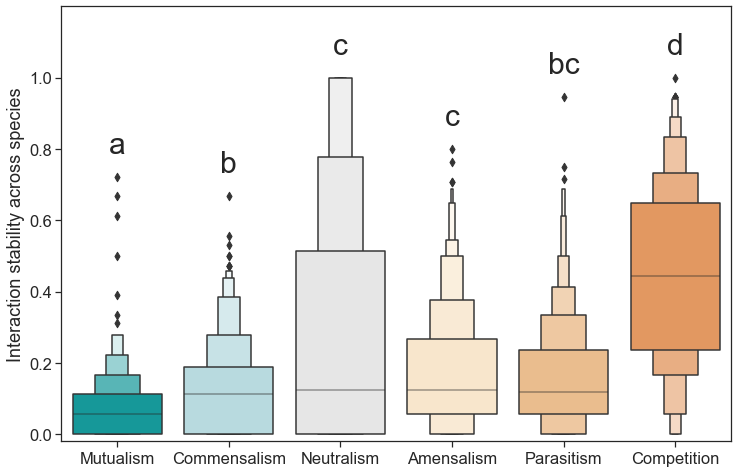

In [15]:
order = ['Mutualism', 'Commensalism', 'Neutralism', 'Amensalism', 'Parasitism', 'Competition']
pal = {'Mutualism': '#00AEAF', 
       'Commensalism':'#B2DFE5', 
       'Neutralism':'#E6E6E6', 
       'Amensalism':'#FFE7C5', 
       'Parasitism':'#FABD7E', 
       'Competition':'#F7954C'}

fig, ax = subplots(figsize=(12,8))
sns.boxenplot(data=partner_stability, x='class', y='stability', palette=pal, order=order)
ax.set_xlabel('')
# ax.set_ylabel('Stability\n(prob. of same interaction class in different env)', ma='center')
ax.set_ylabel('Interaction stability across species', ma='center')

partner_stability_max = partner_stability.groupby('class').max()
for i,c in enumerate(order):
    y = 0.05 + partner_stability_max.loc[c, 'stability']
    s = letters[c]
    ax.text(i, y, s, ha='center', va='bottom', fontsize=30)
    
ax.set_ylim(-.02,1.2)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# savefig('Interaction_stability_partners.png', dpi=300, bbox_inches='tight')

In [16]:
s_name = 'stability_across_species'
ps.to_excel(pval_file, sheet_name=s_name)
partner_stability.to_excel(data_file, sheet_name=s_name)

## Claculate the quantitative changes in interactions

### across carbon environments

In [17]:
from scipy.spatial.distance import pdist,squareform

In [18]:
c12 = '1 on 2: Effect'
c21 = '2 on 1: Effect'

def get_interaction_distance(g):
    '''
    Calculate the (Euclidean) distances of between interactions within a group (g) of interaction strengths.
    
    Each interaction is given by the strengths of effects of the two species on each other.
    
    The distances are average distances from all interactions of a given class and other interactions chosen from the group at random.
    
    If the group represents all the interactions of a pair of species across carbon environments, this corresponds to the "distance across environemts". 
    If the group represents all the interactions of a given species in a given carbon env across other species, this corresponds to the "distance across species".
    '''
    effects = g[[c12,c21]]
    d_mat = pd.DataFrame(squareform(pdist(effects)), index= effects.index)
    n = d_mat.shape[0]
    d_avg = d_mat.sum(axis=1)/(n-1.)
    d_class = pd.concat([d_avg, g['Class']], axis=1).groupby('Class').mean()

    if 'Inconclusive' in d_class.index:
        d_class.drop('Inconclusive', inplace=True)

    return d_class

In [19]:
c_dist = g_bugs.apply(get_interaction_distance)
c_dist = c_dist.reset_index().rename(columns={'Class':'class',0:'distance'})

In [20]:
## compute all pairwise p-values
ps = sp.posthoc_dunn(c_dist, val_col='distance', group_col='class', p_adjust = 'bonferroni').loc[order,order]

## get the compact letter display 
letters = get_letters(ps)

(0.5, 5.5)

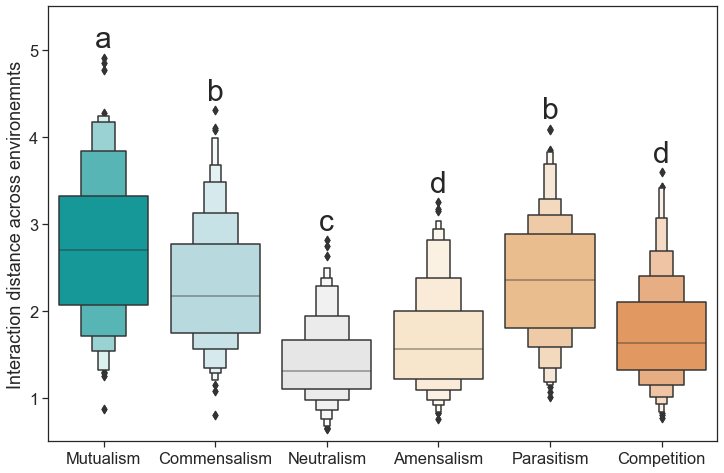

In [21]:
fig, ax = subplots(figsize=(12,8))
sns.boxenplot(data=c_dist, x='class', y='distance', palette=pal, order=order)
ax.set_xlabel('')
# ax.set_ylabel('Stability\n(prob. of same interaction class in different env)', ma='center')
ax.set_ylabel('Interaction distance across environemnts', ma='center')

d_max = c_dist.groupby('class').max()
for i,c in enumerate(order):
    y = 0.05 + d_max.loc[c, 'distance']
    s = letters[c]
    ax.text(i, y, s, ha='center', va='bottom', fontsize=30)
    
ax.set_ylim(0.5,5.5)
# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# savefig('Interaction_distance_env.png', dpi=300, bbox_inches='tight')

In [22]:
s_name = 'distance_across_environments'
ps.to_excel(pval_file, sheet_name=s_name)
c_dist.to_excel(data_file, sheet_name=s_name)

### distance across partners

In [23]:
partner_dist = g_carbon.apply(get_interaction_distance)
partner_dist = partner_dist.reset_index().rename(columns={'Class':'class',0:'distance'})

In [24]:
## compute all pairwise p-values
ps = sp.posthoc_dunn(partner_dist, val_col='distance', group_col='class', p_adjust = 'bonferroni').loc[order,order]

In [25]:
letters = {'Mutualism': 'ad', 
       'Commensalism':'a', 
       'Neutralism':'b', 
       'Amensalism':'c', 
       'Parasitism':'d', 
       'Competition':'c'}

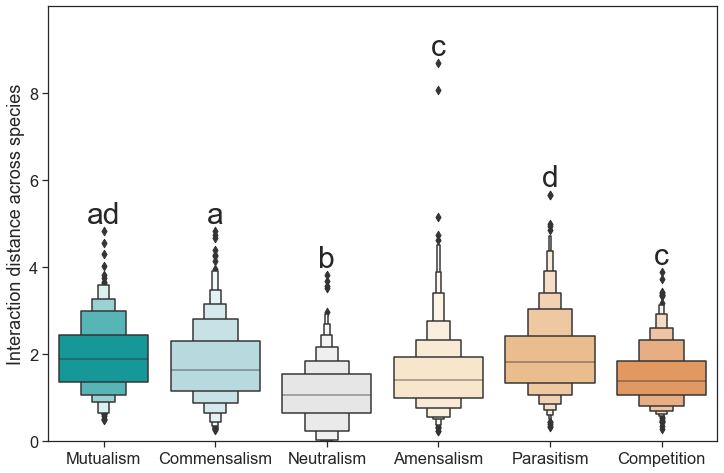

In [26]:
fig, ax = subplots(figsize=(12,8))
sns.boxenplot(data=partner_dist, x='class', y='distance', palette=pal, order=order)
ax.set_xlabel('')
# ax.set_ylabel('Stability\n(prob. of same interaction class in different env)', ma='center')
ax.set_ylabel('Interaction distance across species', ma='center')

partner_d_max = partner_dist.groupby('class').max()
for i,c in enumerate(order):
    y = 0.05 + partner_d_max.loc[c, 'distance']
    s = letters[c]
    ax.text(i, y, s, ha='center', va='bottom', fontsize=30)
    
ax.set_ylim(0,10)
ax.set_yticks(arange(0,9,2))
# savefig('Interaction_distance_partners.png', dpi=300, bbox_inches='tight')

In [27]:
s_name = 'distance_across_species'
ps.to_excel(pval_file, sheet_name=s_name)
partner_dist.to_excel(data_file, sheet_name=s_name)

data_file.close()
pval_file.close()